In [1]:
# Added validation dataset implementation
# Added best model
# Added model hyperparameters in a config dictionary for better organization
# Added Save and load model capability (useful for deploying or reusing later)
# Added a function to do predictions on new data

In [3]:
# Import Modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import copy 

AttributeError: partially initialized module 'torch' has no attribute 'autograd' (most likely due to a circular import)

In [3]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cpu


In [4]:
# Define Data to be used
x = np.linspace(-0.7*np.pi, 0.7*np.pi, 1000)
y = np.sin(x)

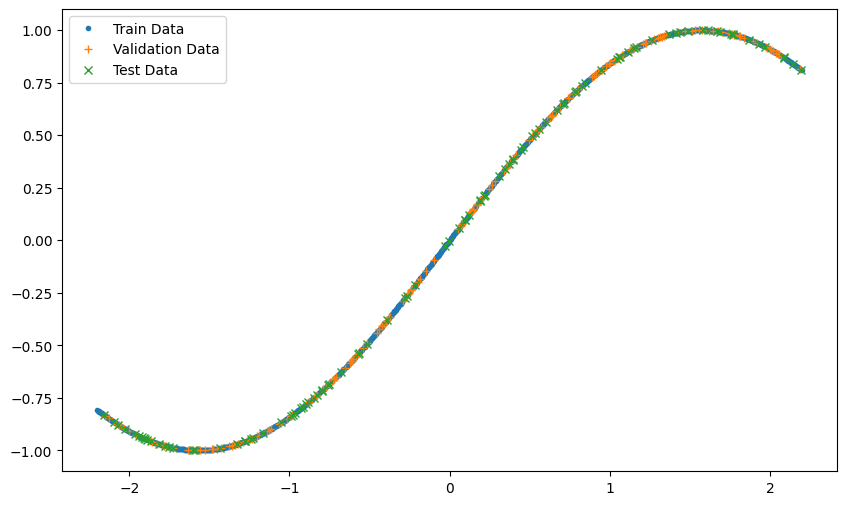

In [5]:
# Split data into train, validation, and test sets
x_train_temp, x_test, y_train_temp, y_test = train_test_split(x, y, test_size=0.1, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train_temp, y_train_temp, test_size=0.2, shuffle=True)

# Visualize all data splits
plt.figure(figsize=(10, 6))
plt.plot(x_train, y_train, '.', label='Train Data')
plt.plot(x_val, y_val, '+', label='Validation Data')
plt.plot(x_test, y_test, 'x', label='Test Data')
plt.legend()
plt.show()

In [6]:
# Convert data to PyTorch Tensors and move to device
x_train = torch.Tensor(x_train).float().view(-1, 1).to(device)
y_train = torch.Tensor(y_train).float().view(-1, 1).to(device)
x_val = torch.Tensor(x_val).float().view(-1, 1).to(device)
y_val = torch.Tensor(y_val).float().view(-1, 1).to(device)
x_test = torch.Tensor(x_test).float().view(-1, 1).to(device)
y_test = torch.Tensor(y_test).float().view(-1, 1).to(device)

In [7]:
# Define Neural Network

# Model Configuration
config = {
    'input_size': 1,
    'hidden_size': 64,
    'output_size': 1,
    'learning_rate': 0.001,
    'batch_size': 100,
    'num_epochs': 100
}

def predict(model, x):
    """Make predictions using the trained model."""
    model.eval()
    with torch.no_grad():
        # Convert input to tensor if it's not already
        if not isinstance(x, torch.Tensor):
            x = torch.Tensor(x).float().view(-1, 1).to(device)
        predictions = model(x)
        return predictions.cpu().numpy().ravel()

# Define Neural Network Architecture
class NN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NN, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x
    
    def save(self, path):
        """Save model parameters."""
        torch.save(self.state_dict(), path)
    
    def load(self, path):
        """Load model parameters."""
        self.load_state_dict(torch.load(path))


# Initialize model using config
model = NN(
    config['input_size'], 
    config['hidden_size'], 
    config['output_size']
).to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), config['learning_rate'])

# Create data loaders for both training and validation
train_dataset = TensorDataset(x_train, y_train)  
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset))

Epoch [10/100], Train Loss: 0.211007, Val Loss: 0.200859
Epoch [20/100], Train Loss: 0.085395, Val Loss: 0.071131
Epoch [30/100], Train Loss: 0.029712, Val Loss: 0.022248
Epoch [40/100], Train Loss: 0.018850, Val Loss: 0.012788
Epoch [50/100], Train Loss: 0.011512, Val Loss: 0.008474
Epoch [60/100], Train Loss: 0.007365, Val Loss: 0.005441
Epoch [70/100], Train Loss: 0.005448, Val Loss: 0.004047
Epoch [80/100], Train Loss: 0.004503, Val Loss: 0.005712
Epoch [90/100], Train Loss: 0.003640, Val Loss: 0.002280
Epoch [100/100], Train Loss: 0.003143, Val Loss: 0.001823
Best validation loss: 0.001823


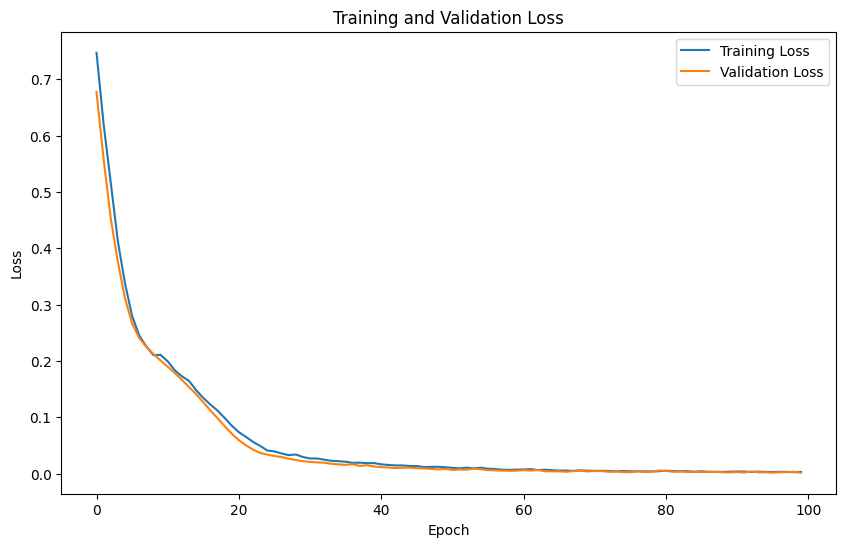

In [8]:
# Define Neural Network Training Parameters
train_losses = []
val_losses = []

# Add variables for tracking best model
best_val_loss = float('inf')
best_model = None

for epoch in range(config['num_epochs']):
    # Training phase
    model.train()
    train_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
        val_losses.append(val_loss.item())
        
        # Save the model if it has the best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)
    
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{config["num_epochs"]}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

print(f'Best validation loss: {best_val_loss:.6f}')

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Test MAE: 0.002273


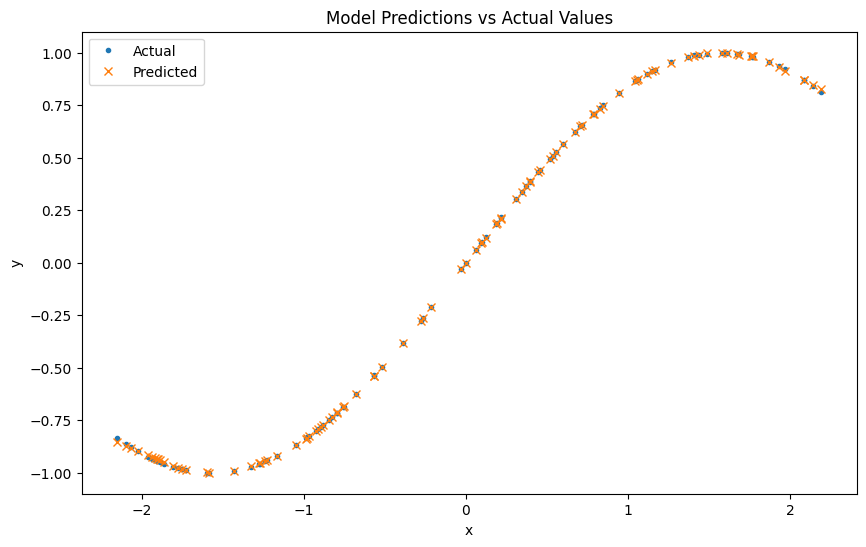

In [9]:
# Save the best model
best_model.save('best_NN_Model.pth')

# Use the best model for final evaluation
model = best_model

# Evaluate Mean Absolute Error of Model on test set
with torch.no_grad():
    model.eval()
    predictions = model(x_test)  
    mae = torch.mean(torch.abs(predictions - y_test))
    print(f'Test MAE: {mae.item():.6f}')
    
    
# Plot predicted value vs actual value
plt.figure(figsize=(10, 6))
prd = predictions.cpu().numpy().ravel()  # Move back to CPU for plotting
plt.plot(x_test.cpu().numpy(), y_test.cpu().numpy(), '.', label='Actual')
plt.plot(x_test.cpu().numpy(), prd, 'x', label='Predicted')
plt.title('Model Predictions vs Actual Values')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [10]:
## OPTIONAL 
# Example of how to use the model for new data
new_x = np.linspace(-np.pi, np.pi, 100)  # New data points
predictions = predict(model, new_x)

# Example of how to load and use a saved model
new_model = NN(config['input_size'], config['hidden_size'], config['output_size']).to(device)
new_model.load('best_sine_model.pth')
predictions_from_loaded = predict(new_model, new_x)

C:\Users\Daksh\AppData\Local\Temp\ipykernel_2740\592187861.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))
